## Introduction

The goal of a recommendation engine is to recommend relevant items to a user, based on historical data.
The customer we are working with, is a multi-national company that works on the health sector. They want to predict what products their customers shall need the most, based on their past purchases but also on product and customer features that could lead to a most customized recommendation, whilst also improving the quality of the recommendations.

Personalization is a technique of dynamically tailoring the content based on needs of each user. Simple examples of personalization could be movie recommendation on Netflix, personalized email targeting/re-targeting by e-commerce platforms, item recommendation on Amazon, etc. Personalization helps us achieve these four Rs -
- Recognize: Know customer’s and prospects’ profiles, including demographics, geography, and expressed and shared interests.
- Remember: Recall customers’ history, primarily how they act as expressed by what they browse and buy
- Reach: Deliver the right promotion, content, recommendation for a customer based on actions, preferences, and interests
- Relevance: Deliver personalization within the context of the digital experience based on who customers are, where they are located and what time of year it is

Why personalization?

<br>
Personalization has a lot of benefits for both users and companies. For users, it makes their life easy as they only get to see more relevant stuff to them (unless it’s an advertisement, even they are personalized). For business benefits are countless but here are few which I would like to mention -
- Enhance customer experience: Personalization reduces the clutter and enhances the customer experience by showing relevant content
- Cross-sell/ Up-sell opportunities: Relevant product offerings based on customer preferences can lead to increasing products visibility and eventually selling more products
- Increased basket size: Personalized experience and targeting ultimately leads to increased basket size and frequent purchases
- Increased customer loyalty: In the digital world, customer retention/loyalty is the most prominent problem faced by many companies as finding a replacement for a particular service is quite easy. According to a Forbes article, Forty-four percent of consumers say they will likely repeat after a personalized experience


## Project Scope

The customer we are working with, is a multi-national company that works on the health sector. They want to predict what products their customers shall need the most, based on their past purchases but also on product and customer features that could lead to a most customized recommendation, whilst also improving the quality of the recommendations.

We have performed 3 models in order to decide which is the best recommendation engine to our client. 


This project has been divided into 5 ordered different Jupyter Notebooks:

| Order | Name | Description | 
| --- | --- |  --- | 
| 1 | Recommendation Engine - EDA | Contains the data exploration and pre-processing for both profiling and modeling  |
| 2 | Recommendation Engine - Profiling | Contains the customer segmentation via clustering |
| 3 | Recommendation Engine - Modeling (Popularity) | Contains the popularity recommendation engine via Linux (WSL) |
| 4 | Recommendation Engine - Modeling | Contains the collaborative filtering and hybrid recommendation engines and all the model's output and comparison |
| 5 | Recommendation Engine - Deployment | Contains instructions on how to deploy the model |

## Libraries

In [1]:
import warnings

from typing import Dict, List, Tuple
from datetime import datetime

# Preprocessing
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# Recommendation
#import implicit

warnings.filterwarnings('ignore')
%matplotlib inline

# Exploratory Data Analysis

## Products Dataset

| Variable | Description |
| --- | --- | 
| bravo_ww_fran_name | company designation for the global group |
| bravo_fran_name | company designation for a region of the group |
| bravo_sub_fran_name | company area |
| bravo_major_name | product family |
| bravo_minor_name | product sub-family |
| product_code | product code |

In [2]:
product_master = pd.read_csv(r'data/product_master.csv')
product_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24693 entries, 0 to 24692
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bravo_ww_fran_name   24693 non-null  object
 1   bravo_fran_name      24693 non-null  object
 2   bravo_sub_fran_name  24693 non-null  object
 3   bravo_major_name     24693 non-null  object
 4   bravo_minor_name     24693 non-null  object
 5   product_code         24693 non-null  object
dtypes: object(6)
memory usage: 1.1+ MB


### Handling Missing Values

The previous output shows there are no missing values hence, this section shall be skipped.

### Rename Features

The dataframe's current structure isn't particularly informative; we have then replaced the default feature names with a clear and informative set.

In [9]:
product_master.head(2)

,bravo_ww_fran_name,bravo_fran_name,bravo_sub_fran_name,bravo_major_name,bravo_minor_name,product_code
0,bravo_ww_fran_name_0,bravo_fran_name_0,bravo_sub_fran_name_0,bravo_major_name_0,bravo_minor_name_0,product_code_0
1,bravo_ww_fran_name_1,bravo_fran_name_1,bravo_sub_fran_name_1,bravo_major_name_1,bravo_minor_name_1,product_code_1


In [3]:
# Renaming columns
product_master.rename(columns={"bravo_ww_fran_name": "group", 
                               "bravo_fran_name": "region_group",
                              "bravo_sub_fran_name": "company_area",
                              "bravo_major_name": "product_family",
                              "bravo_minor_name": "product_subfamily"}, inplace=True)

In [4]:
# Renaming text of the columns
product_master.replace(["bravo_ww_fran_name", "bravo_fran_name", "bravo_sub_fran_name", "bravo_major_name", "bravo_minor_name"],
                       value=["group", "region","company_area","product_family", "product_subfamily"], regex=True, inplace=True)

### Utilities

In [5]:
def generate_bar_labels(graph: matplotlib.pyplot.figure):
    '''
    Generates the data labels for each bar in a matplotlib figure.
    '''
    for p in graph.patches:
        patch_width: float = p.get_width()
        
        graph.text(patch_width + 100, p.get_y() + p.get_height() / 2., str(int(patch_width)), color='black', ha='left', va='center')
        

### Handle Sparse Data Clusters

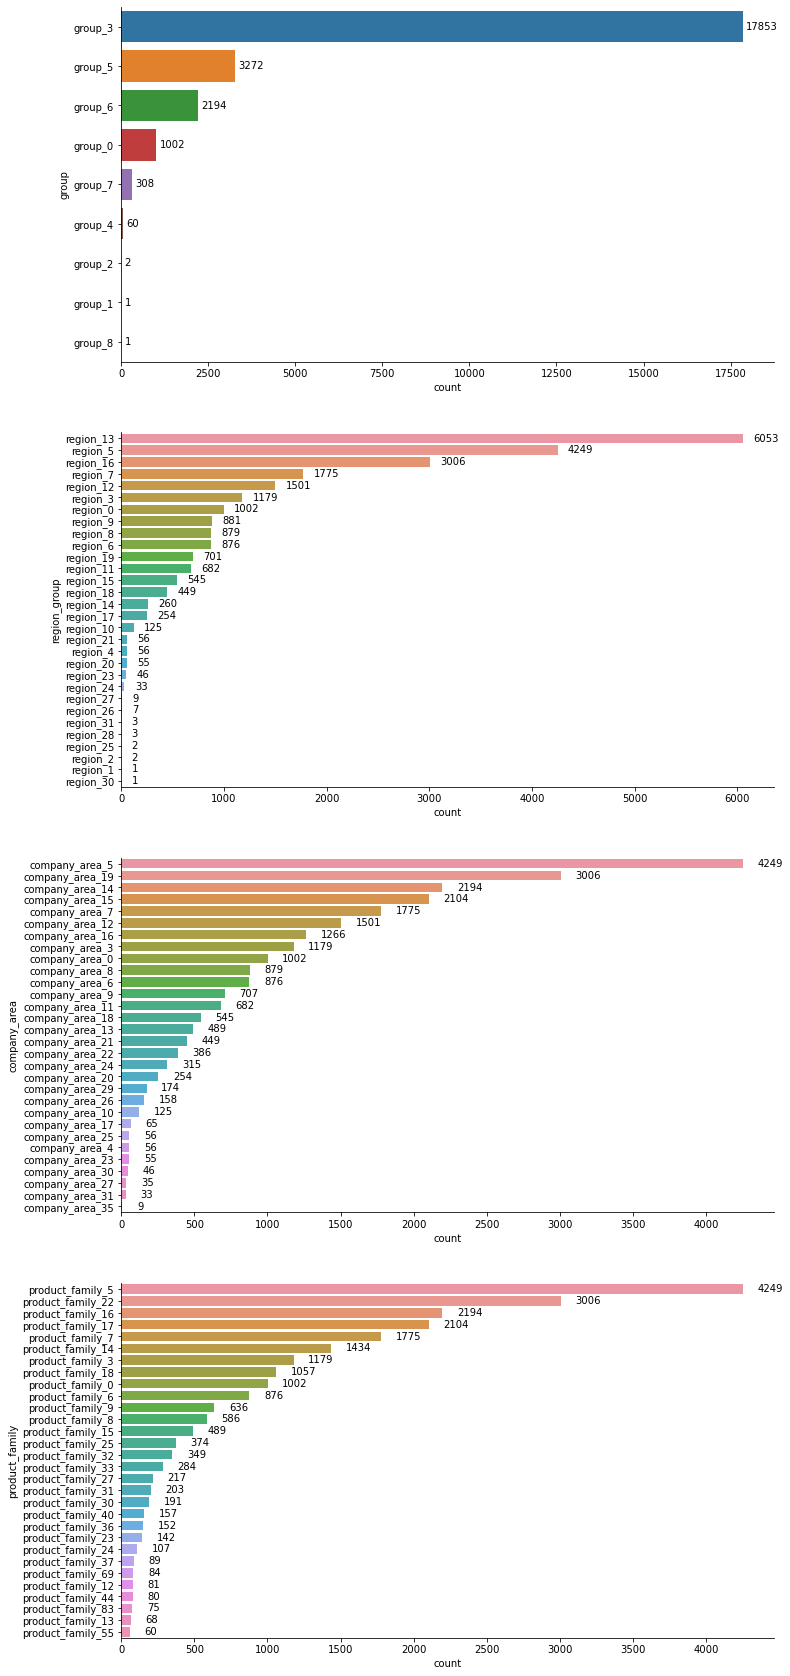

In [6]:
# Barplot

variables=["group",
          "region_group",
          "company_area",
          "product_family",
          ]
count_label: str = 'count'
max_items: int = 30
    
a4_dims = (11.7, 30)
fig, ax = plt.subplots(len(variables) , figsize=a4_dims)


for i, var in enumerate(variables):
    subset = product_master[var].value_counts().nlargest(max_items).to_frame().reset_index()
    subset.columns = [var, count_label]
    graph = sns.barplot(y= var
               ,x = count_label
               ,data= subset
              ,ax = ax[i]
                 )
    # Plot the actual counts
    generate_bar_labels(graph)
    sns.despine()

The plots above indicate we may run into a cold-start problem for several cases where the number of records is small. 

Typically the records may either be removed or grouped into a single cluster. The latter option allows the items to still be recommended, and increasing their recommendation likelihood, given this they then represent a single group/cluster.

Due to this fact, smaller groups of data have been aggregated onto a common cluster thus decreasing the cold start's impact and allowing the model to achieve statistical significance on these classes.

The previous plots showcase a strong concentration of purchases in **company global group 3, 5 and 6**, in descending order. Similarly, **regions 13, 5 and 16** aggregate 35% of all purchases. As for the company areas, whilst the concentration appears to decrease, it is still rather relevant, with **areas 5, 19 and 14** accounting for a large portion of the transactions. Lastly, the product family showcases a similar behavior, with **product families 4,22 and 16** representing the largest portion of purchases.

We have opted to aggregate groups portraing **less than 65** observations.

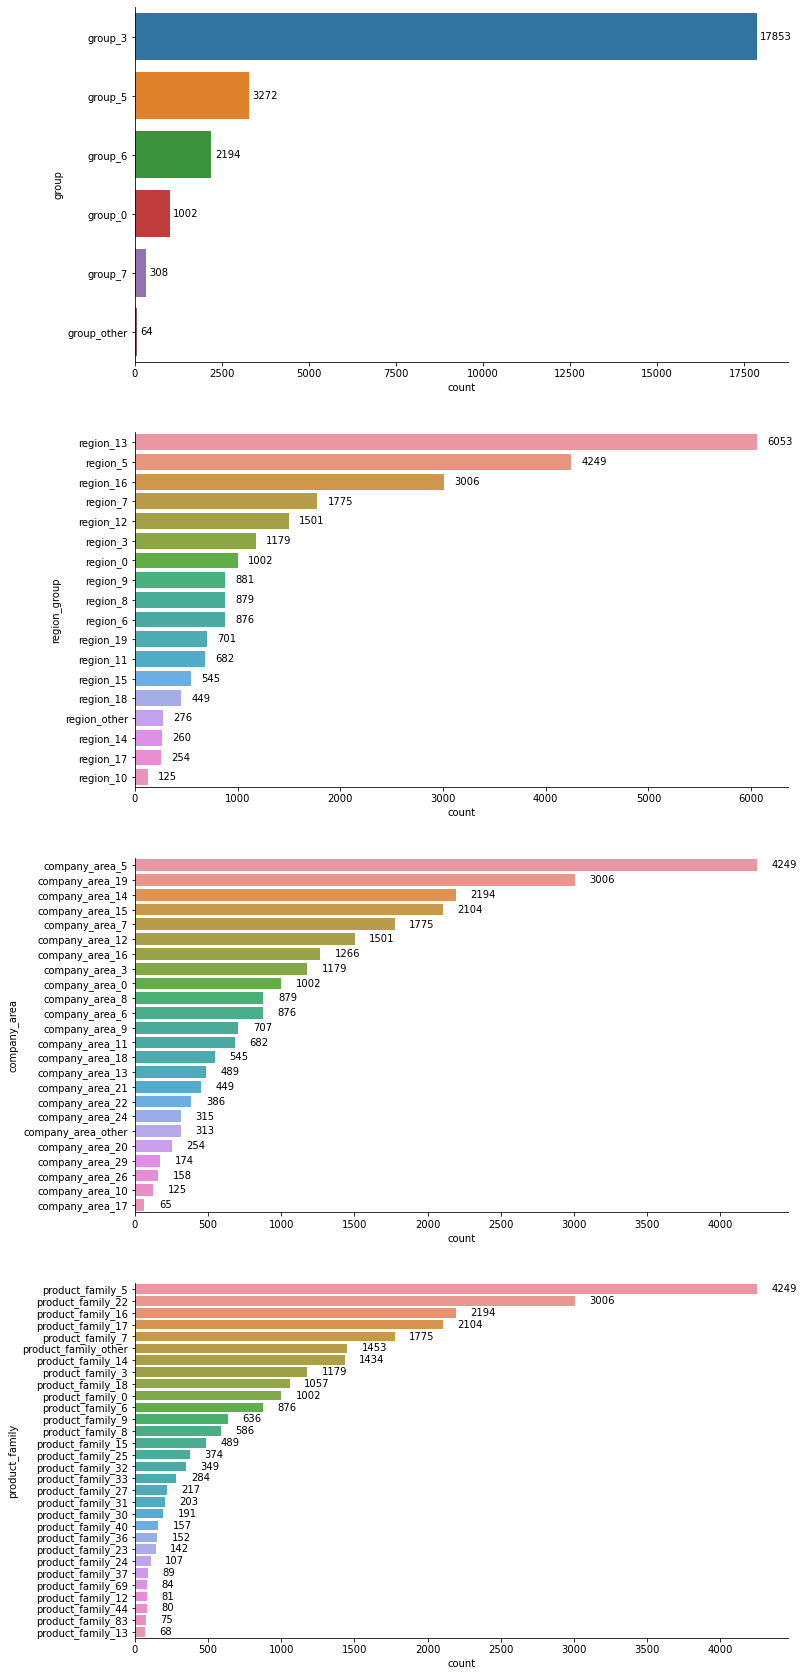

In [8]:
variable_template: Dict = {
    "group": "group_",
    "region_group": "region_",
    "company_area": "company_area_",
    "product_family": "product_family_"
    #"product_subfamily": "product_subfamily"
                          }
    
count_label: str = 'count'
max_items: int = 40
# The cluster threshold defines the frequency under which categories are grouped
cluster_threshold: int =  65
    
a4_dims = (11.7, 30)
fig, ax = plt.subplots(len(variable_template) , figsize=a4_dims)

for i, var in enumerate(variable_template.keys()):
    dataset: pd.DataFrame = product_master[var]
    # Select the items to be combined into a single category
    subset: pd.DataFrame = dataset.value_counts().reset_index()
    subset_cluster: List[str] = subset[subset[var] < cluster_threshold]['index'].to_list()
    if len(subset_cluster) > 0:
        dataset.replace(subset_cluster, value = variable_template.get(var) + 'other', regex = False, inplace = True)
    
    subset: pd.DataFrame = dataset.value_counts().nlargest(max_items).to_frame().reset_index()
    subset.columns = [var, count_label]
    graph = sns.barplot(y= var
               ,x = count_label
               ,data= subset
              ,ax = ax[i]
                 )

    # Plot the actual counts
    generate_bar_labels(graph)
    sns.despine()

# Exploratory Data Analysis
## Purchase Log Dataset

The focus now shifts to analysing the purchasing history or log; referred to as stock in the original prospect.

The log contains information regarding the transitioned product, where it was purchased at, its date, volume and amount of transitioned product at said point in time.

| Variable | Description |
| --- | --- | 
| country_code | The country's code |
| cac | The customer code |
| product_code |  The transitioned product's code |
| month_code | Sale year and month |
| invoiced_sales | Sale value |
| volume_primary_units | Number of sold units  |
| inventory_cost | Cost of the product for the company (unitary cost multiplied by volume) |

In [9]:
stock = pd.read_csv(r'data/stock.csv', decimal = ',' , 
                    dtype={'invoiced_sales': float, 'volume_primary_units': object
                           , 'inventory_cost': float, 'month_code': str})

In [32]:
stock.head(2)

,country_code,cac,product_code,month_code,invoiced_sales,volume_primary_units,inventory_cost
0,country_code_0,cac_0,product_code_0,190001.0,0.0,0,0.0
1,country_code_0,cac_0,product_code_1,190001.0,0.0,0,0.0


In [10]:
stock.info(null_counts= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5199686 entries, 0 to 5199685
Data columns (total 7 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   country_code          5199686 non-null  object 
 1   cac                   5199686 non-null  object 
 2   product_code          5199686 non-null  object 
 3   month_code            5199685 non-null  object 
 4   invoiced_sales        5199685 non-null  float64
 5   volume_primary_units  5199685 non-null  object 
 6   inventory_cost        5199685 non-null  float64
dtypes: float64(2), object(5)
memory usage: 277.7+ MB


In [11]:
# transform the variable volume_primary_units to numeric
stock['volume_primary_units'] = stock['volume_primary_units'].str.replace(',', '.')
stock['volume_primary_units'] = pd.to_numeric(stock['volume_primary_units'])

## Data Cleansing

### Analyze products with no transaction value

The next point of interest is to analyze cases where the log contains zero-valued entries, as these may signify invalid or useless data.

In [12]:
stock[(stock['invoiced_sales'] == 0) | (stock['volume_primary_units'] == 0)].count()

country_code            806100
cac                     806100
product_code            806100
month_code              806100
invoiced_sales          806100
volume_primary_units    806100
inventory_cost          806100
dtype: int64

The typical response would be to remove these items as they do not create added value to the model, resulting instead in wasting both cpu-cycles and ram.

However, for recommendation engines keeping them is actually good practice, given they may result in products with a very low likelihood of being recommended, but still possible. In addition, should the transaction log increase, these items have already been pre-processed hence incorporated into the model, removing the need for new EDA and pre-processing.

### Analyze transactions with missing information

Transactions with missing information may require data imputation to avoid losing useful information the model may capture.

In [13]:
stock[stock.isna().any(axis=1)]

,country_code,cac,product_code,month_code,invoiced_sales,volume_primary_units,inventory_cost
5199685,country_code_3,cac_9501,product_code_57985,NaN,NaN,NaN,NaN


In [36]:
stock[stock.product_code == 'product_code_57985']

,country_code,cac,product_code,month_code,invoiced_sales,volume_primary_units,inventory_cost
5199685,country_code_3,cac_9501,product_code_57985,NaN,NaN,NaN,NaN


There is only one case of products with missing data.

This seems to be an edge case, where the log does not contain valid values. Since the product only appears once, and does not contain any information, the record has been deemed invalid as an inexisting product (for instance, due to internal testing), hence, it was removed.

In [14]:
# resulting in uneeded memory and cpu cycles
stock.dropna(inplace=True)

### Analyze Refunds

Refunds represent another typical case which would result in said records being removed or even, removing all records of products associated with refunds, so as to prevent models from recommending highly refunded products.

However, this is is not the case for recommendation engines. The rationale used to process this data has been clarified in "Recommendation Engine - Modeling", the section where these alterations were processed.

We have opted for not handling refunds at this time, as this notebook's output is a set of general-purpose processed data, specifically, data which can be used both for clustering and recommendation engines.

In [44]:
refunds = stock[(stock["invoiced_sales"]<0)]
print(refunds.count())
print()
print()

print('Refunds in {product_count} products, at a total volume of {units} units.'.format(
    product_count = len(refunds.product_code.unique()),
    units = int(-refunds.volume_primary_units.sum())
))

country_code            111255
cac                     111255
product_code            111255
month_code              111255
invoiced_sales          111255
volume_primary_units    111255
inventory_cost          111255
dtype: int64


Refunds in 23969 products, at a total volume of 824025 units.


In [43]:
stock["invoiced_sales"][(stock["invoiced_sales"]<0)].count()/len(stock["invoiced_sales"])*100

2.1396488441126724

There are 111.255 total refunds, in 23.969 products for a total of 824.025 refunded units, representing 2.14% of total sales.

These refunds occur more often in the following items:

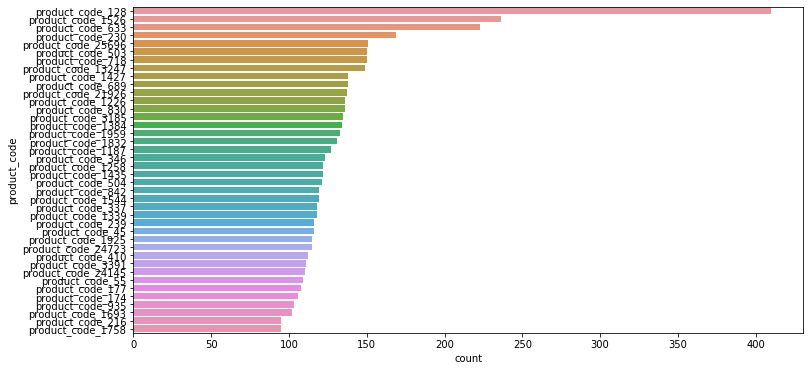

In [46]:
count_label: str = 'count'
max_items: int = 40
    
refunds: pd.DataFrame = refunds['product_code'].value_counts().nlargest(max_items).to_frame().reset_index()
refunds.columns = ["product_code", count_label]

a4_dims = (12,6)
fig, ax = plt.subplots(1 , figsize=a4_dims) 

graph1 = sns.barplot(y= "product_code"
               ,x = count_label
               ,data= refunds
                 )

### Compare Invoiced Sales with Inventory Cost

In [15]:
product_stats = pd.DataFrame(stock.groupby(['product_code'])[["inventory_cost", "invoiced_sales", "volume_primary_units"]].agg("sum"))

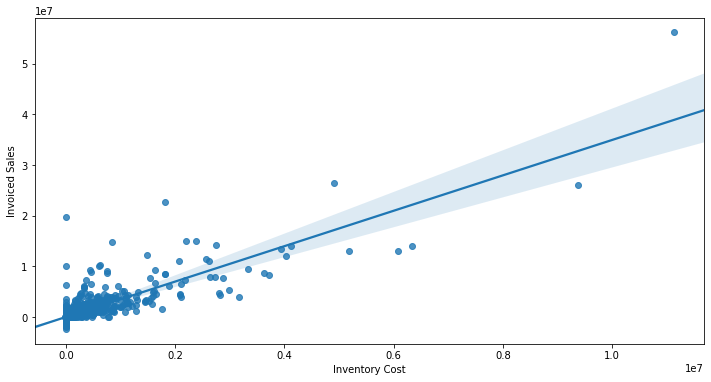

In [49]:
a4_dims = (12,6)
fig, ax = plt.subplots(1 , figsize=a4_dims) 

#plt.scatter(x="inventory_cost",y="invoiced_sales", data = product_stats)
sns.regplot(x="inventory_cost",y="invoiced_sales", data = product_stats)

plt.xlabel("Inventory Cost")
plt.ylabel("Invoiced Sales");

As expected, the previous figure showcases a clear positive but not perfect correlation between the number of purchased items and their total cost. This suggests that higher transactioned amounts are associated with decreasing unitary costs; another possibility is that discounts are given for bulk orders.

### Invoiced Sales vs Volume Primary Units

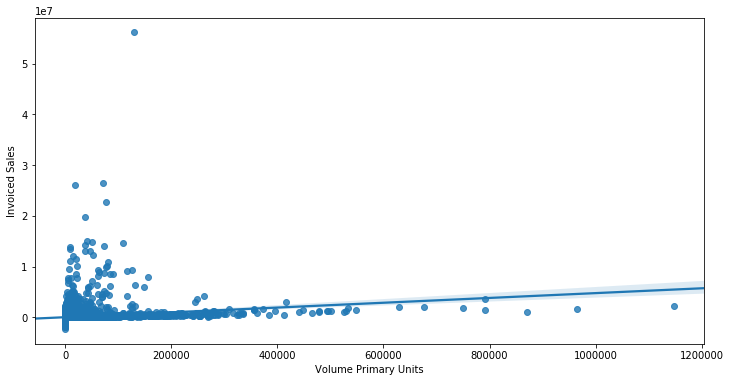

In [50]:
fig, ax = plt.subplots(1 , figsize=a4_dims) 
#plt.scatter(x="volume_primary_units",y="invoiced_sales", data = product_stats)

sns.regplot(x="volume_primary_units",y="invoiced_sales", data = product_stats)
plt.xlabel("Volume Primary Units")
plt.ylabel("Invoiced Sales");

# Feature Engineering & Exploration

The section aims at producing high-valued features which may help identify specific consumption patterns whilst at the same time, exploring the newly generated features.


| Variable | Description |
| --- | --- | 
| unitary_cost | The customer code |
| profit |  The transitioned product's code |
| unitary_profit | Sale year and month |
| average_profit | Sale value |
| transaction_year | The sale's year  |
| transaction_month | The sale's month |
| is_peak_period | Has the transaction taken place in a peak period (quarter) |
| is_top_selling | Is the item a top-selling item |
| profit_percent | The transaction's profit percent regarding its cost |
| profit_bin | The transaction's profit binned into 10 buckets |
| cost_bin | The transaction's cost binned into 10 buckets |

### Cost and Profit Transaction Features

In [16]:
# Format data
stock = stock.astype({'invoiced_sales': float, 'volume_primary_units': float, 'inventory_cost': float})

stock['log_date'] = pd.to_datetime(stock['month_code'].apply(lambda x: x.replace('.0', '')), format = '%Y%m')
stock['unitary_cost'] = stock.inventory_cost / stock.volume_primary_units
stock['profit'] = stock.invoiced_sales - stock.inventory_cost
stock['unitary_profit'] = stock.profit / stock.volume_primary_units  

### Analyze each product's average margin

In [17]:
product_margins = pd.DataFrame(stock.groupby(['product_code'])[['unitary_profit', 'unitary_cost']].agg("mean"))
product_margins.columns = ["average_profit", "average_cost"]

The most profitable products are:

In [18]:
product_margins.sort_values(by = 'average_profit', ascending = False).nlargest(10, ['average_profit'])

,average_profit,average_cost
product_code,,
product_code_14542,inf,2.350704
product_code_57208,inf,72.595284
product_code_18718,inf,138.915374
product_code_18708,inf,43.312000
product_code_18692,inf,14.548628
product_code_18687,inf,inf
product_code_18679,inf,-inf
product_code_13484,inf,10.012117
product_code_4689,inf,inf


We established a clean base dataset containing the altered data and considering only transactions occured from 2018 onwards given a lot of transactions occured with no specified/valid date.

In [19]:
stock = stock[stock['log_date'] > '2018-01-01']

### Analyse the average transaction volume

In [55]:
# Group customer and product code 
customer_log: pd.DataFrame = stock.groupby(['cac', 'product_code']).agg(
    sales_value=pd.NamedAgg(column='invoiced_sales', aggfunc=sum),
    sales_number=pd.NamedAgg(column='invoiced_sales', aggfunc='count'),
    volume_value =pd.NamedAgg(column='volume_primary_units', aggfunc=sum),
    cost_value=pd.NamedAgg(column='inventory_cost', aggfunc=sum),

).reset_index()

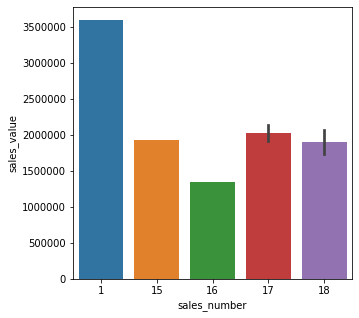

In [56]:
customer_subset: pd.DataFrame = customer_log[['sales_number', 'sales_value']].nlargest(7, columns = 'sales_value').reset_index()
fig, ax = plt.subplots(1 ,figsize=(5,5))    

graph = sns.barplot(y= 'sales_value'
           ,x = 'sales_number'
           ,data= customer_subset
             )

The plot clearly shows that most transactions represent a single unit acquisition; however, the bulk of sales represent volumes between 15 and 18 units, which may represent small dimension low-cost highly disposable medical items (such as masks, bandages, and other non-steralizeable items).

### Analyse the top purchasing customers

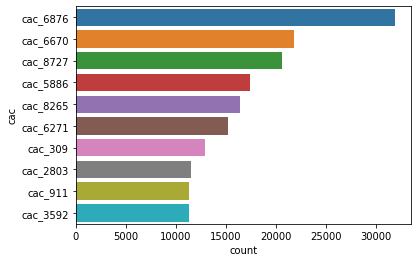

In [58]:
count_label: str = 'count'
max_items: int = 10
customer: pd.DataFrame = stock['cac'].value_counts().nlargest(max_items).to_frame().reset_index()
customer.columns = ["cac", count_label]

graph = sns.barplot(y= "cac"
               ,x = count_label
               ,data= customer
             
                 )

The plot shows there is a distinct customer which represents a large portion of sales: **cac_6670**, followed by other customers with small variations between one another.

### Analyze sales evolution

The focus is now shifted for year-on-year sales evolution.

In [20]:
sales_evolution: pd.DataFrame = stock.copy()

sales_evolution.rename(columns={"product_code": "number_of_products", 
                               "cac": "number_of_clients"
                               }, inplace=True)    
    
sales_evolution['transaction_year'] = pd.to_datetime(sales_evolution['log_date']).dt.to_period('Y')

sales_evolution.groupby('transaction_year').agg({
    'volume_primary_units': 'count',
    'profit': 'sum',
    'number_of_products': 'nunique',
    'number_of_clients': 'nunique'
    }
)

,volume_primary_units,profit,number_of_products,number_of_clients
transaction_year,,,,
2018,2904487,1.063969e+09,45498,7531
2019,1729825,6.373759e+08,39386,6691


Apparently, sales do decrease, but this is only because the fiscal year 2019 was not complete at the time of the log.
The following table showcases the same figures considering only the first semester of each year.

In [21]:
sales_evolution: pd.DataFrame = stock.copy()

sales_evolution.rename(columns={"product_code": "number_of_products", 
                               "cac": "number_of_clients"
                               }, inplace=True) 
    
 
    
sales_evolution['transaction_year'] = pd.to_datetime(sales_evolution['log_date']).dt.to_period('Y')
sales_evolution['transaction_month'] = pd.to_datetime(sales_evolution['log_date']).dt.month

sales_evolution = sales_evolution[sales_evolution['transaction_month'] < 7]
sales_evolution.groupby('transaction_year').agg({
    'volume_primary_units': 'count',
    'profit': 'sum',
    "number_of_products": 'nunique',
    'number_of_clients': 'nunique'
    }
)

,volume_primary_units,profit,number_of_products,number_of_clients
transaction_year,,,,
2018,1331824,5.023159e+08,39838,6526
2019,1525273,5.631887e+08,38544,6556


Although the global scenery remained the same, the number of transactioned units increased slightly.

### Ascertain the existance of seasonality

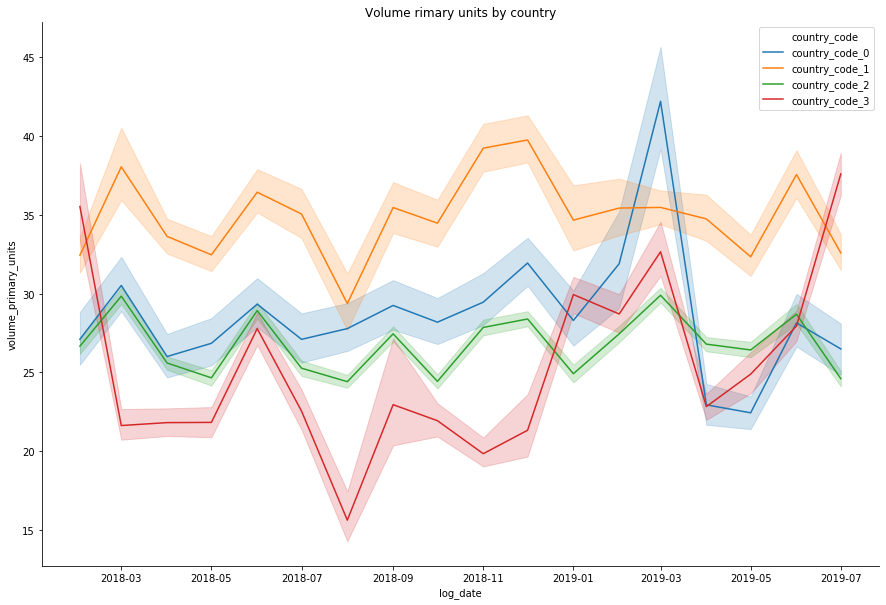

In [70]:
a4_dims: Tuple[float, float] = (15, 10)
fig, ax = plt.subplots(1, figsize = a4_dims)
sns.lineplot(data = stock, x = 'log_date', y='volume_primary_units', hue = 'country_code').set_title('Volume primary units by country')
sns.despine()

The previous figure showcases a U-Shape (sharp decrease) of sales in each 2-month period. This suggests a seasonal effect, specifically, a 3-month lagged term. Hence, a flag has been created to tag every 3-month (quarter) cycle.

In [22]:
stock['is_peak_period'] = stock['log_date'].apply(lambda x: 1 if int(x.month % 3 == 0) else 0)

In [23]:
# Reset the slice given its been updated
stock: pd.DataFrame = stock[stock['log_date'] > '2018-01-01']
stock[(stock['log_date'] == '2019-06-01') | (stock['log_date'] == '2019-07-01')].head(5)

,country_code,cac,product_code,month_code,invoiced_sales,volume_primary_units,inventory_cost,log_date,unitary_cost,profit,unitary_profit,is_peak_period
21,country_code_0,cac_3,product_code_21,201906.0,0.000000,0.0,0.000000,2019-06-01,NaN,0.000000,NaN,1
37,country_code_0,cac_3,product_code_36,201906.0,-105.317917,-1.0,-51.500000,2019-06-01,51.500000,-53.817917,53.817917,1
39,country_code_0,cac_3,product_code_38,201907.0,79.730701,2.0,18.966037,2019-07-01,9.483019,60.764664,30.382332,0
42,country_code_0,cac_3,product_code_41,201906.0,422.739514,1.0,178.083145,2019-06-01,178.083145,244.656370,244.656370,1
43,country_code_0,cac_3,product_code_42,201906.0,106.229761,5.0,19.531588,2019-06-01,3.906318,86.698172,17.339634,1


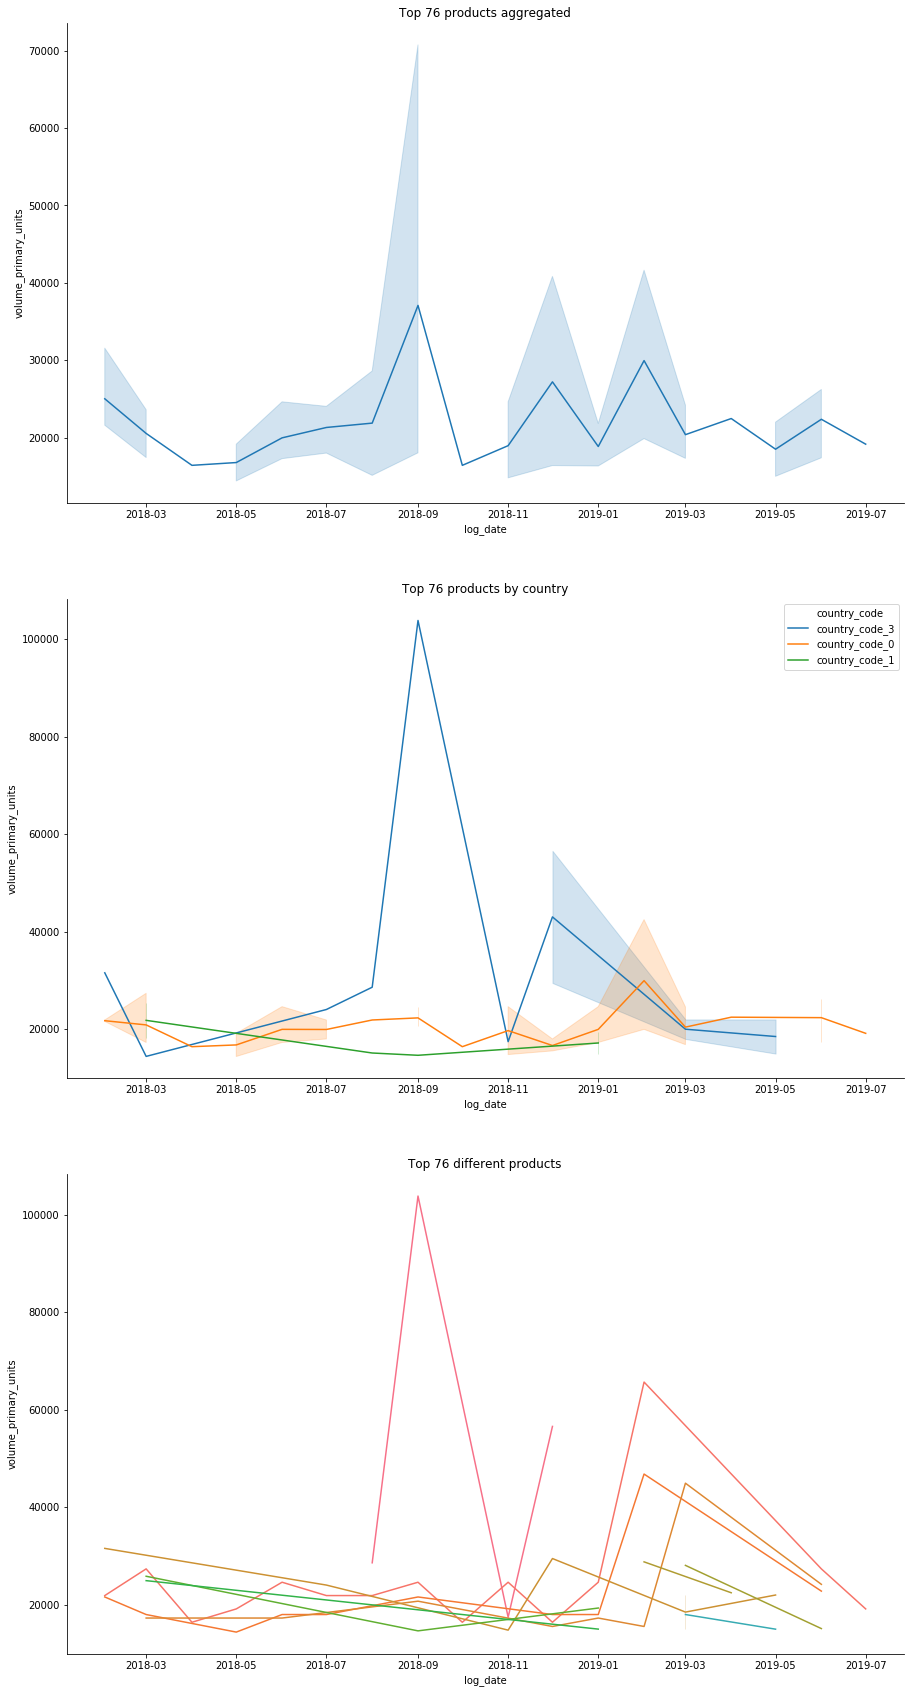

In [71]:
a4_dims =  (15, 30)
fig, ax = plt.subplots(3, figsize = a4_dims)
max_items = 76

subset: pd.DataFrame = stock[['log_date','country_code','product_code', 'volume_primary_units']].nlargest(max_items, columns = 'volume_primary_units').reset_index()

# Global Top 76
sns.lineplot(data = subset, x = 'log_date', y='volume_primary_units', ax = ax[0]).set_title('Top 76 products aggregated')
sns.despine()

# Top 76 per Country
sns.lineplot(data = subset, x = 'log_date', y='volume_primary_units', hue = 'country_code', ax = ax[1]).set_title('Top 76 products by country')
sns.despine()

# Top 76 per Product Code
sns.lineplot(data = subset, x = 'log_date', y='volume_primary_units', hue = 'product_code', ax = ax[2]).set_title('Top 76 different products')
sns.despine()
ax[2].get_legend().remove()

Although not easily perceivable, the **3-month seasonality does not seem to occur in the top 76 ordered products**, generally speaking. This suggests an expected behavior: the seasonality is likely to be located in less consumed products.
Note: The choice with the 76 threshold is due to the fact that the 76th highest selling product still presents no seasonality.

Its wortwhile mentioning that the sales in terms of the top 26 items in country 2 have drastically increased from 2019-01 onward. This seems to be related with the global increase in sale of a specific product from 2019-01 onward.

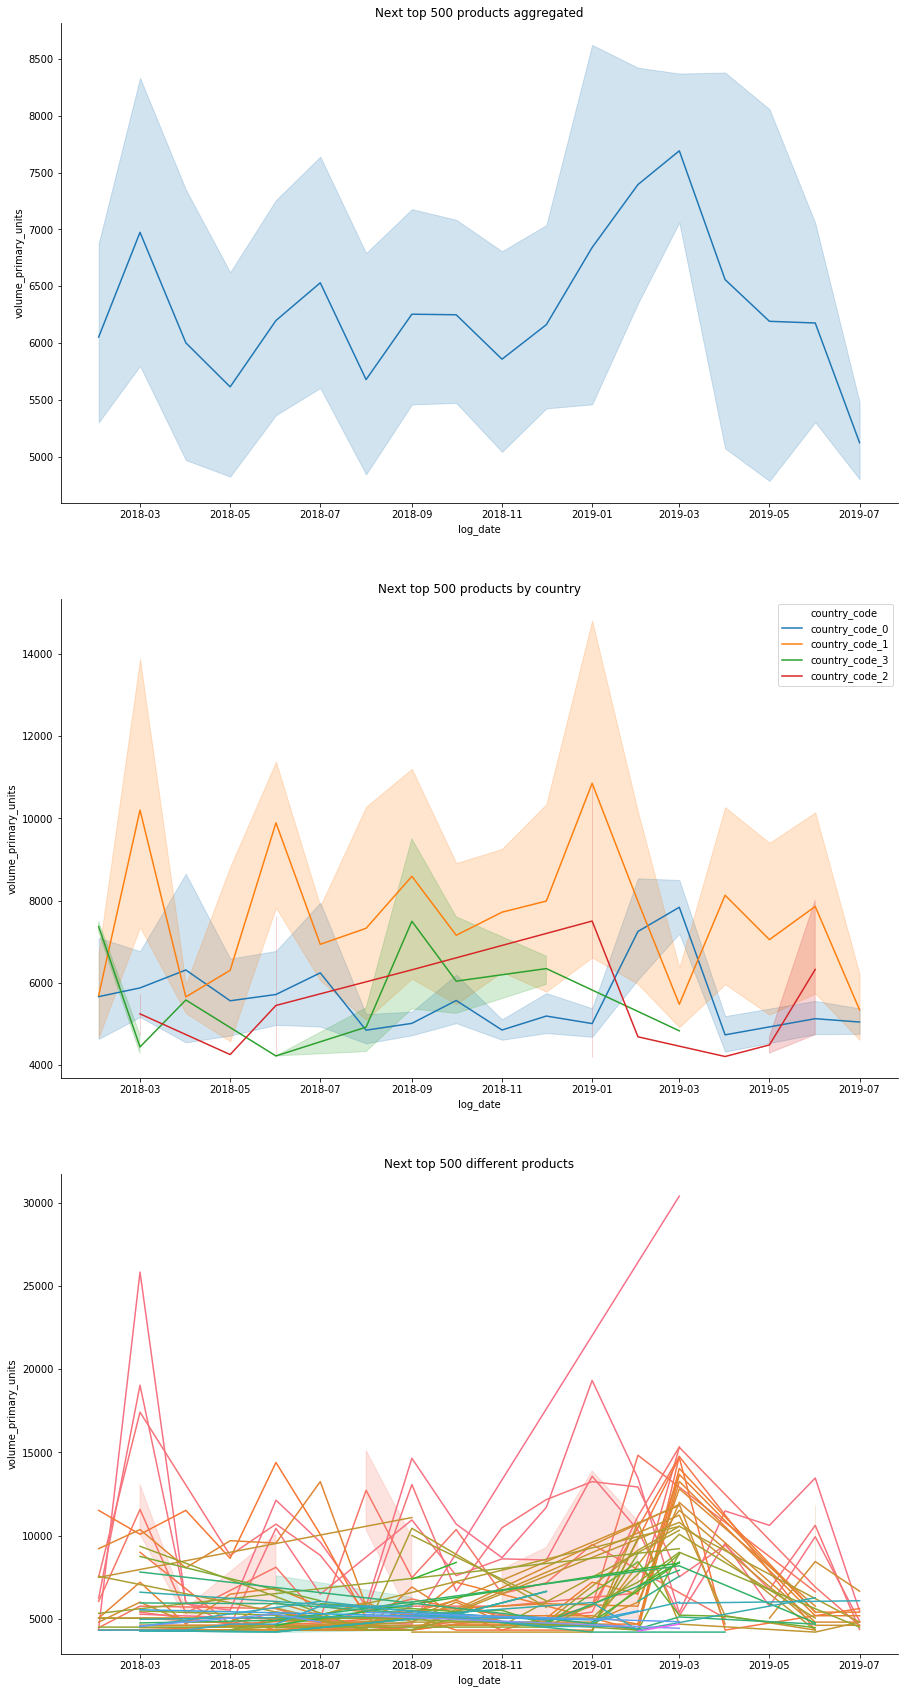

In [73]:
product_log: pd.DataFrame = stock.groupby('product_code').agg(
    volume_value =pd.NamedAgg(column='volume_primary_units', aggfunc=sum),
    ).reset_index()

# Tag the top 76 products and remove them, so the next 500 highest products items can be tracked
top_76_items: List[str] = product_log.nlargest(max_items, columns = 'volume_value').product_code.unique().tolist()
subset = stock[~stock.product_code.isin(top_76_items)].nlargest(500, columns = 'volume_primary_units').reset_index()

fig, ax = plt.subplots(3, figsize= a4_dims)

# Next Global Top 500
graph = sns.lineplot(data = subset, x = 'log_date', y='volume_primary_units', ax = ax[0]).set_title('Next top 500 products aggregated')
sns.despine()

# Next Top 500 per Country
graph = sns.lineplot(data = subset, x = 'log_date', y='volume_primary_units', hue = 'country_code', ax = ax[1]).set_title('Next top 500 products by country')
sns.despine()

# Next Top 500 per Product Code
graph = sns.lineplot(data = subset, x = 'log_date', y='volume_primary_units', hue = 'product_code', ax = ax[2]).set_title('Next top 500 different products')
sns.despine()
ax[2].get_legend().remove()

As previously noted, the seasonality seems to be focused on less-selling products (non top-76 selling products). Its stacked or cumulative effect is heavy; outbalancing the top-76 sales'. However, the effect seems to be less well-defined, whereas some products showcase a quarterly seasonality peaking on the regular quarters, others seem to be offset by a month.

There is a clear distinction between the behavior of top 76 selling and the remainder of the product's general behavior. For this reason, we decided to create a **flag tagging said behavior**.
At the same time, the **is_peak_period flag** needs to be reset for cases where the item is top selling given that seasonality is not present.

In [24]:
stock['is_top_selling'] = stock.product_code.isin(top_76_items).astype(int)
stock.is_peak_period = stock.is_peak_period * stock.is_top_selling.apply(lambda x: x^1)

# Reset the slice given its been updated
stock = stock[stock['log_date'] > '2018-01-01']

stock[stock.is_top_selling == 0]['is_peak_period'].nunique()

NameError: name 'top_76_items' is not defined

In [80]:
#stock[(stock['is_peak_period']==True) & (stock['is_top_selling']==True) ]

### Profit Margin

Compute the percentual profit margin to aid euclidean distance computation via normalized standardized values

In [ ]:
product_stats_percent: pd.DataFrame = stock.groupby(['country_code','product_code'])[['profit', 'inventory_cost']] \
    .agg(sum).reset_index()
product_stats_percent['profit_percent'] = product_stats_percent['profit'] / product_stats_percent['inventory_cost']
stock['profit_percent'] = stock.merge(product_stats_percent, on= ['country_code','product_code'], how= 'left').profit_percent

### Merge the processed stock (transaction log) and product_master (product information) data

In [26]:
full_data: pd.DataFrame = stock.merge(product_master, on= 'product_code', how= 'left')

In [27]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4634312 entries, 0 to 4634311
Data columns (total 17 columns):
 #   Column                Dtype         
---  ------                -----         
 0   country_code          object        
 1   cac                   object        
 2   product_code          object        
 3   month_code            object        
 4   invoiced_sales        float64       
 5   volume_primary_units  float64       
 6   inventory_cost        float64       
 7   log_date              datetime64[ns]
 8   unitary_cost          float64       
 9   profit                float64       
 10  unitary_profit        float64       
 11  is_peak_period        int64         
 12  group                 object        
 13  region_group          object        
 14  company_area          object        
 15  product_family        object        
 16  product_subfamily     object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(9)
memory usage: 636.4+ MB


### Account for correlation

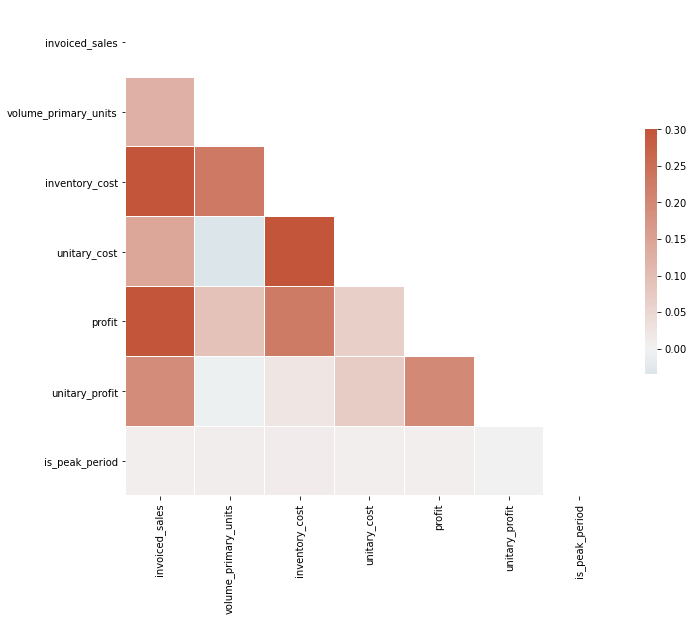

In [30]:
corr = full_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr
            ,mask=mask
            ,cmap=cmap
            ,vmax=.3
            ,center=0,
            square=True
            ,linewidths=.5
            ,cbar_kws={"shrink": .5}
           )

The data does not present highly correlated features so there is no need to remove any of them.

### Ascertain the need for different models based on country
In other words, if there are different product distributions per country

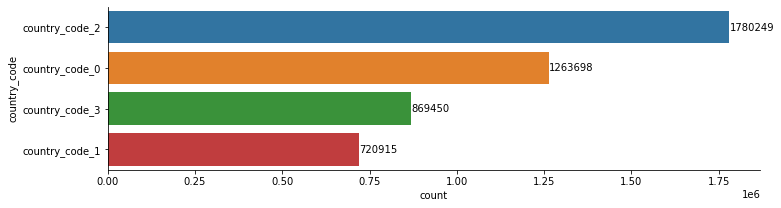

In [32]:
variable: str = "country_code"
count_label: str = 'count'
max_items: int = 30
    
a4_dims = (11.7, 3)
fig, ax = plt.subplots(1 , figsize=a4_dims)

subset = full_data[variable].value_counts().nlargest(max_items).to_frame().reset_index()
subset.columns = [variable, count_label]
graph = sns.barplot(y= variable
           ,x = count_label
           ,data= subset
          ,ax = ax
             )
# Plot the actual counts
generate_bar_labels(graph)
sns.despine()

### Ascertain differences at the main levels

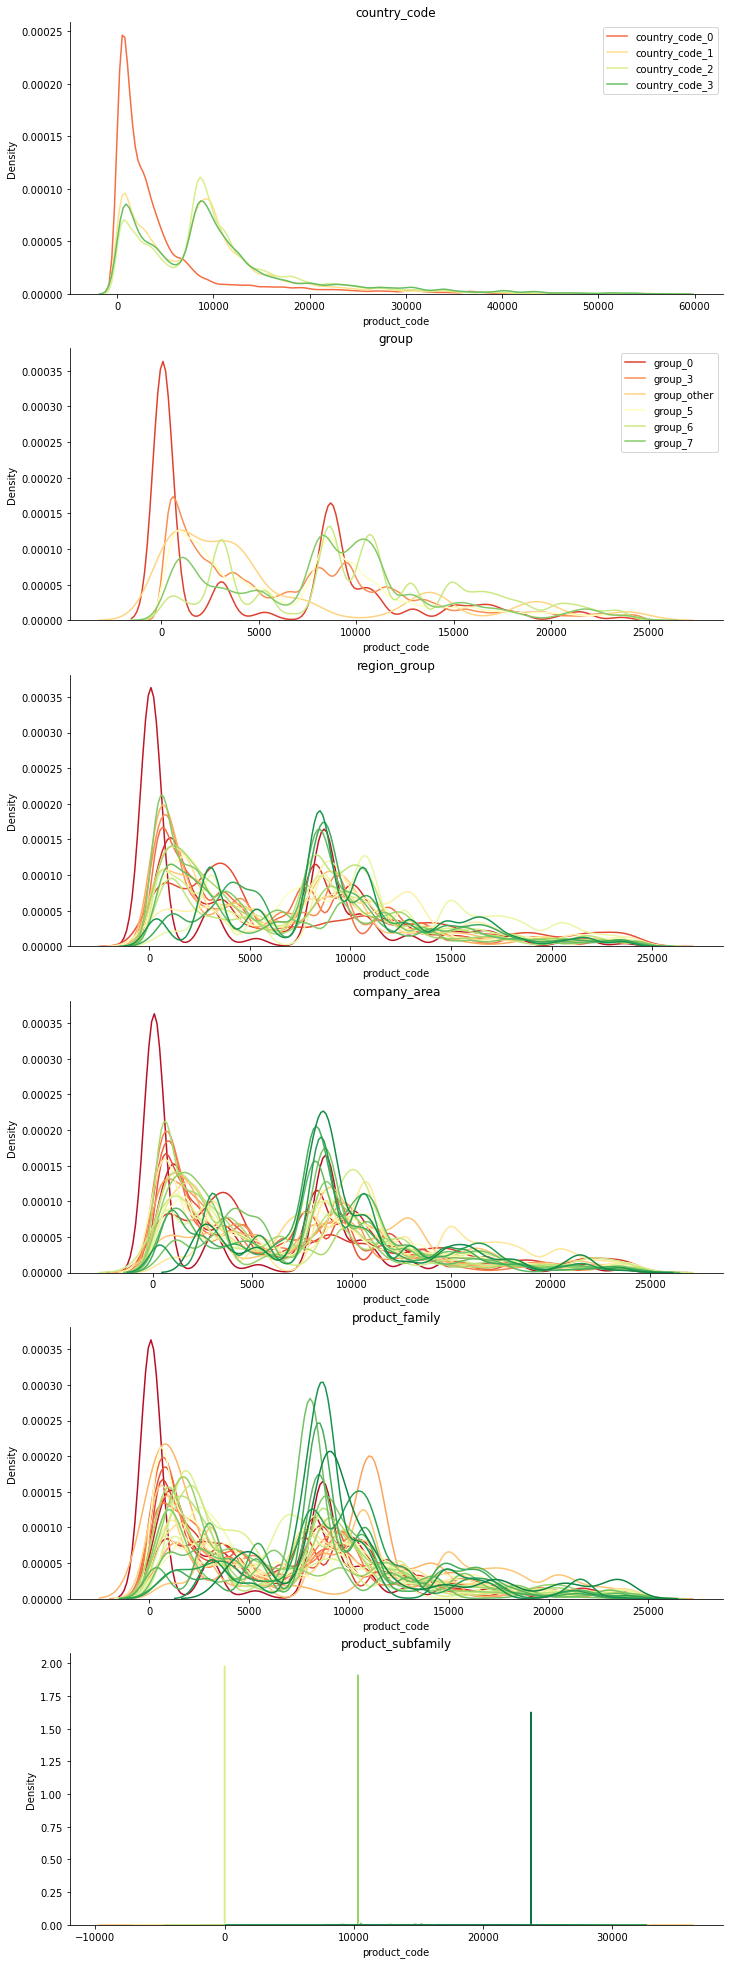

In [33]:
product_variable: str = 'product_code'
variables: List = ['country_code', 'group', 'region_group', 'company_area', 'product_family', 'product_subfamily', product_variable]
hue_variables: List = full_data.country_code.unique().tolist()
subset = full_data[variables]

# Convert the product code to int so we can plot its distribution
subset[product_variable] = subset[product_variable].str.replace(product_variable + '_', '').astype(int)
hue_variables: List = full_data.country_code.unique().tolist()
    
count_label: str = 'count'
max_items: int = 30    
    
a4_dims = (11.7, 5* len(variables))
fig, ax = plt.subplots(len(variables) -1, figsize=a4_dims)
    
# Remove the product_code from the iterable variables' list
variables.remove(product_variable)
for n, var in enumerate(variables):
    hue_variables: List = full_data[var].unique().tolist()
    palette = sns.color_palette('RdYlGn', len(hue_variables))
    for i, hue_var in enumerate(hue_variables):
        graph = sns.distplot(
                subset[subset[var] == hue_var][product_variable]
                ,color = palette[i]
                ,label = hue_var
                ,hist = False
                ,ax = ax[n]
        )

        sns.despine()
    
    ax[n].title.set_text(var)
    if len(hue_variables) < 10:
        ax[n].legend()
    

This analysis revealed that it might make sense to create separate models contingent on the user's country:
- **country_code_0** seems to have a uniquely well-behaved distribution
- **country_code_1**, **country_code_2** and **country_code_3** have a similar purchase distribution hence, it might make sense to create a separate model for these countries as the generated embedings can capture the user's behavior more closely

### Categorical Feature Engineering

Most recommendation systems rely on the use of User/Item matrices which tag the number of interactions per each User/Item combination. The process called, matrix factorization, relies on the ability to represent these interactions in a 2D matrix,  interpreted via cosine similarity. Hence, categorical features instead of continuous are needed, which will form the rows and columns of the analysis.

We have then opted for creating a ranking of profitability per product: if we remove the number value we lose the gross profitability data, relying instead on just the percentual margin which is relative; by creating cost buckets a ranking can still be attained compromising the floating point accuracy for categorical data the recommendation engine can use. 

In [34]:
product_stats_rank: pd.DataFrame = full_data.groupby(['product_code'])[['profit', 'inventory_cost']].sum().reset_index()
product_stats_rank.sort_values(by= 'profit', ascending= False)

bin_number: int = 10
bin_tags: List = [x for x in range(1, bin_number + 1)]
    
product_stats_rank['profit_bin'] = \
    pd.cut(product_stats_rank.sort_values(by= 'profit', ascending= False).profit, bin_number, labels= bin_tags)

product_stats_rank['cost_bin'] = \
    pd.cut(product_stats_rank.sort_values(by= 'inventory_cost', ascending= False).profit, bin_number, labels= bin_tags)

full_data = full_data.merge(product_stats_rank[['product_code', 'profit_bin', 'cost_bin']], on= 'product_code', how= 'left')
full_data

,country_code,cac,product_code,month_code,invoiced_sales,volume_primary_units,inventory_cost,log_date,unitary_cost,profit,unitary_profit,is_peak_period,group,region_group,company_area,product_family,product_subfamily,profit_bin,cost_bin
0,country_code_0,cac_3,product_code_20,201804.0,95.098599,4.0,24.409992,2018-04-01,6.102498,70.688607,17.672152,0,group_0,region_0,company_area_0,product_family_0,product_subfamily_0,1,1
1,country_code_0,cac_3,product_code_21,201906.0,0.000000,0.0,0.000000,2019-06-01,NaN,0.000000,NaN,1,group_0,region_0,company_area_0,product_family_0,product_subfamily_0,1,1
2,country_code_0,cac_3,product_code_22,201902.0,-773.621317,-1.0,-236.550000,2019-02-01,236.550000,-537.071317,537.071317,0,group_0,region_0,company_area_0,product_family_0,product_subfamily_0,1,1
3,country_code_0,cac_3,product_code_23,201812.0,375.423736,6.0,108.936137,2018-12-01,18.156023,266.487599,44.414600,1,group_0,region_0,company_area_0,product_family_0,product_subfamily_0,2,2
4,country_code_0,cac_3,product_code_24,201804.0,9.396435,1.0,6.690796,2018-04-01,6.690796,2.705639,2.705639,0,group_0,region_0,company_area_0,product_family_0,product_subfamily_0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4634307,country_code_2,cac_9503,product_code_12830,201810.0,78.950000,5.0,34.093856,2018-10-01,6.818771,44.856144,8.971229,0,group_6,region_other,company_area_other,product_family_other,product_subfamily_108,1,1
4634308,country_code_2,cac_9503,product_code_1679,201807.0,913.520000,288.0,184.184605,2018-07-01,0.639530,729.335395,2.532415,0,group_3,region_16,company_area_19,product_family_22,product_subfamily_50,1,1
4634309,country_code_2,cac_9503,product_code_477,201804.0,467.800000,2.0,258.380000,2018-04-01,129.190000,209.420000,104.710000,0,group_3,region_13,company_area_16,product_family_18,product_subfamily_36,1,1
4634310,country_code_3,cac_9449,product_code_2004,201807.0,142.800000,1.0,59.493563,2018-07-01,59.493563,83.306437,83.306437,0,group_3,region_7,company_area_7,product_family_7,product_subfamily_23,1,1


#### Dump the selected information to a CSV so it can be handled in a separate notebook, decreasing the memory footprint

Two different sets to data have been saved:
- **data_clean_recommendation** represents the processed data with recommendation engine targeted features
- **data_clean_cluster** in turn, contains clustering/profiling specific features

In [134]:
#data_clean_recommendation
full_data.drop(['inventory_cost', 'unitary_cost', 'unitary_profit', 'profit', 'is_top_selling'
                , 'profit_percent'] ,axis= 1).to_csv('data_clean_recommendation.csv', index = False)

In [135]:
#data_clean_cluster
full_data.drop(['month_code', 'inventory_cost', 'profit', 'is_top_selling'
                , 'profit_percent', 'profit_bin', 'cost_bin'] ,axis= 1).to_csv('data_clean_cluster.csv', index = False)

In [137]:
#full_data